In [1]:
# Importing in each cell because of the kernel restarts.

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scrapy
import re
from scrapy.crawler import CrawlerProcess

class ESSpider(scrapy.Spider):
    # Naming the spider is important if you are running more than one spider of
    # this class simultaneously.
    name = "ESS"
    
    # URL(s) to start with.
    start_urls = [
        'https://www.bestbuy.com/site/tvs/all-flat-screen-tvs/abcat0101001.c?id=abcat0101001',
    ]

    # Use XPath to parse the response we get.
    def parse(self, response):
        
        print('Reading New Page')
        #Iterate over every <article> element on the page.
        for article in response.xpath('//li[@class="sku-item"]'):
            
            # Yield a dictionary with the values we want.
            yield {
                'sku': article.xpath('@data-sku-id').extract(),
                'name': article.xpath('.//h4[@class="sku-header"]/a/text()').extract(),
                'review' : article.xpath('.//p[@class="sr-only"]/text()').extract(),
                'price' : article.xpath('.//div[@class="priceView-hero-price priceView-purchase-price"]/span/text()').extract(),
                'save' : article.xpath('.//div[@class="pricing-price__savings"]/text()').extract(),
                'openbox' : article.xpath('.//div[@class="priceView-open-box-link-medium"]/text()').extract(),
                'availability1' : article.xpath('.//button[@class="btn btn-primary btn-sm btn-block btn-leading-ficon add-to-cart-button"]/text()').extract(),
                'availability2' : article.xpath('.//button[@class="btn btn-secondary btn-sm btn-block add-to-cart-button"]/text()').extract(),
#                 'date': article.xpath('header/section/span[@class="entry-date"]/text()').extract_first(),
#                 'text': article.xpath('section[@class="entry-content"]/p/text()').extract(),
#                 'tags': article.xpath('*/span[@class="tag-links"]/a/text()').extract()
            }
        # Get the URL of the previous page.
        next_page = response.xpath('//a[@class="ficon-caret-right trans-button "]/@href').extract_first()
        
#         # There are a LOT of pages here.  For our example, we'll just scrape the first 9.
#         # This finds the page number. The next segment of code prevents us from going beyond page 9.
#         pagenum = response.xpath('.//div[@class]')
#         pagenum = re.findall('(\d{1,3})\sof\s(\d{1,3})\sitems',next_page
#         print(pagenum)
                             
        
        # Recursively call the spider to run on the next page, if it exists.
        if next_page is not None:
            next_page = response.urljoin(next_page)
            # Request the next page and recursively parse it the same way we did above
            yield scrapy.Request(next_page, callback=self.parse)

# Tell the script how to run the crawler by passing in settings.
# The new settings have to do with scraping etiquette.          
process = CrawlerProcess({
    'FEED_FORMAT': 'json',         # Store data in JSON format.
    'FEED_URI': 'data.json',       # Name our storage file.
    'LOG_ENABLED': False,          # Turn off logging for now.
    'ROBOTSTXT_OBEY': True,
    'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
    'AUTOTHROTTLE_ENABLED': True,
    'HTTPCACHE_ENABLED': True
})

# Start the crawler with our spider.
process.crawl(ESSpider)
process.start()
print('Success!')

Reading New Page
Reading New Page
Reading New Page
Reading New Page
Reading New Page
Reading New Page
Reading New Page
Reading New Page
Reading New Page
Reading New Page
Reading New Page
Success!


In [3]:
import pandas as pd
raw_data =pd.read_json('data.json', orient='records')
print(raw_data.shape)

(252, 8)


In [4]:
def get_rating(row):
    review = re.findall('Rating:\s(\d\.?\d?).*?with\s(\d{1,5})',row['review'])
    if len(review) > 0:
        rating = float(review[0][0])
        return rating
    else:
        return 0
    

def get_num_ratings(row):
    review = re.findall('Rating:\s(\d\.?\d?).*?with\s(\d{1,5})',row['review'])
    if len(review) > 0:
        num_ratings = float(review[0][1])
        return num_ratings
    else:
        return 0
    

def get_brand(row):
    text = re.findall('\w*',row['name'])
    if len(text) > 0:
        found = text[0]
        return found
    else:
        return ''
 
def get_size(row):
    text = re.search('(\d{1,3})"',row['name'])
    if not text == None:
        return int(text[1])
    else:
        return 0
    
def get_resolution(row):
    text = re.search('(\d{1,5})p\s',row['name'])
    if not text == None:
        return text[1]
    else:
        return 0

def get_class(row):
    text = row['name']
    if 'OLED' in text:
        return 'OLED'
    elif 'LED' in text:
        return 'LED'
    else:
        return ''

    

In [6]:
df = raw_data.copy()

for index, row in df.iterrows():
    for column in df.columns:
        df.loc[index,column] = ''.join(row[column])
        

df['Rating'] = df.apply(lambda row: get_rating(row), axis=1)
df['Num_Ratings'] = df.apply(lambda row: get_num_ratings(row), axis=1)
df.save = df.save.str.replace('Save','')
df.price = df.price.str.replace('$','')
df.price = df.price.str.replace(',','')
df.price = df.apply(lambda row: float(row.price) if len(row.price) > 0 else 0 , axis=1)

df.save = df.save.str.replace('$','')
df.save = df.save.str.replace(',','')
df.save = df.apply(lambda row: float(row.save) if len(row.save) > 0 else '' , axis=1)

df.name = df.name.str.replace('“','"')
df.name = df.name.str.replace('”','"')
df['Brand'] = df.apply(lambda row: get_brand(row), axis=1)
df['Size'] = df.apply(lambda row: get_size(row), axis=1)
df['Resolution'] = df.apply(lambda row: get_resolution(row), axis=1)
df['Class'] = df.apply(lambda row: get_class(row), axis=1)
df['Smart'] = np.where(df.name.str.contains('(S|s)mart'),1,0)
df['Fire'] = np.where(df.name.str.contains('(F|f)ire'),1,0)
df['Roku'] = np.where(df.name.str.contains('(R|r)oku'),1,0)
df['HDR'] = np.where(df.name.str.contains('HDR'),1,0)
df['Outdoor'] = np.where(df.name.str.contains('(O|o)utdoor'),1,0)

df['Avail_InStock'] = np.where(df.availability1 == 'Add to Cart', 1, 0)
df['Avail_OutofStock'] = np.where(df.availability1 == '', 1, 0)

df['Avail_OtherStores'] = np.where(df.availability2 == 'Check Stores', 1, 0)
df['Avail_OutofStock'] = np.where(df.availability2 == 'Check Stores', 0, df['Avail_OutofStock'])
df['Avail_InStock'] = np.where(df.availability2 == 'Check Stores', 0, df['Avail_InStock'])

df.drop(columns=['sku','openbox','review','availability1','availability2'], axis=1, inplace=True)
df.head()

,name,price,save,Rating,Num_Ratings,Brand,Size,Resolution,Class,Smart,Fire,Roku,HDR,Outdoor,Avail_InStock,Avail_OutofStock,Avail_OtherStores
0,"Insignia™ - 24"" Class – LED - 720p – Smart - H...",99.99,50,4.2,24.0,Insignia,24,720,LED,1,1,0,0,0,1,0,0
1,"Toshiba - 43"" Class – LED - 2160p – Smart - 4K...",249.99,80,4.6,428.0,Toshiba,43,2160,LED,1,1,0,1,0,1,0,0
2,"Samsung - 75"" Class - LED - NU6900 Series - 21...",1399.99,100,4.6,12.0,Samsung,75,2160,LED,1,0,0,1,0,1,0,0
3,"Sony - 65"" Class - LED - X900F Series - 2160p ...",1599.99,400,4.8,651.0,Sony,65,2160,LED,1,0,0,1,0,1,0,0
4,"Samsung - 32"" Class - LED - M5300 Series - 108...",279.99,,4.6,1346.0,Samsung,32,1080,LED,1,0,0,0,0,1,0,0


<function matplotlib.pyplot.show(*args, **kw)>

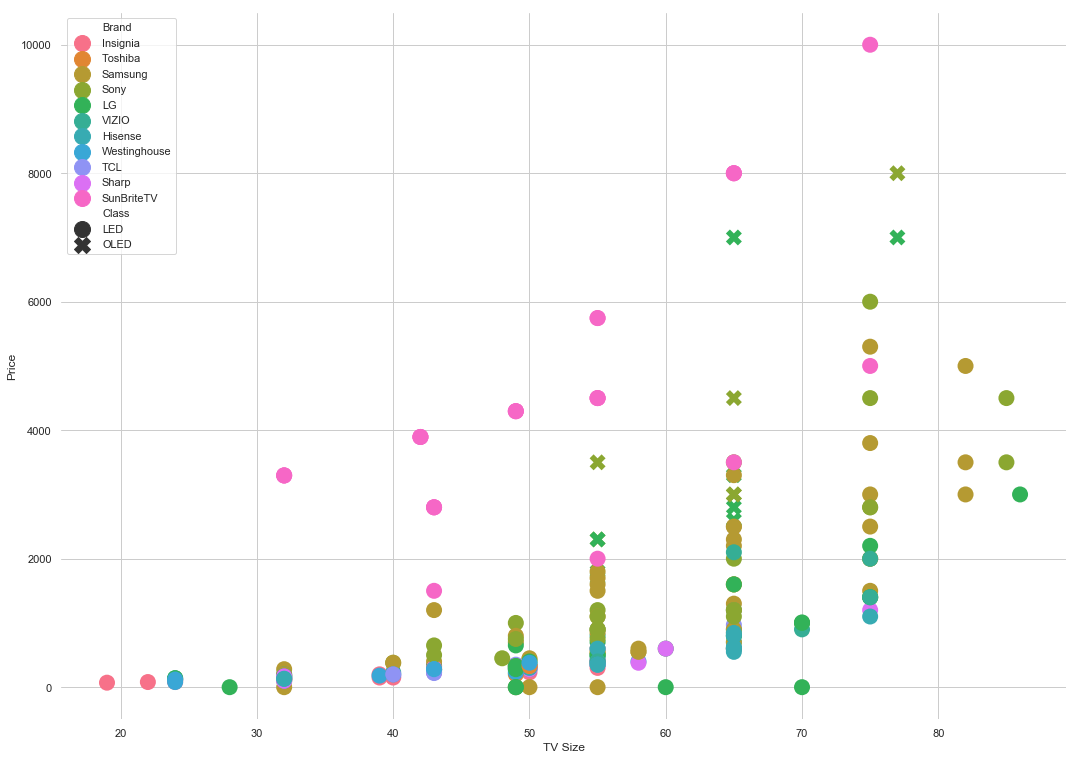

In [7]:
sns.set(style="whitegrid")

# Draw a scatter plot while assigning point colors and sizes to different variables in the dataset

f, ax = plt.subplots(figsize=(18, 13))
sns.despine(f, left=True, bottom=True)
plt.rcParams['lines.markersize'] = 16
plt.rcParams['font.size'] = 30


sns.scatterplot(x="Size", y="price",
                hue="Brand", style='Class', 
                sizes=(1, 10), linewidth=0,
                data=df[(df.price < 10000)],   ax=ax)
plt.xlabel('TV Size')
plt.ylabel('Price')
plt.legend(loc=2)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

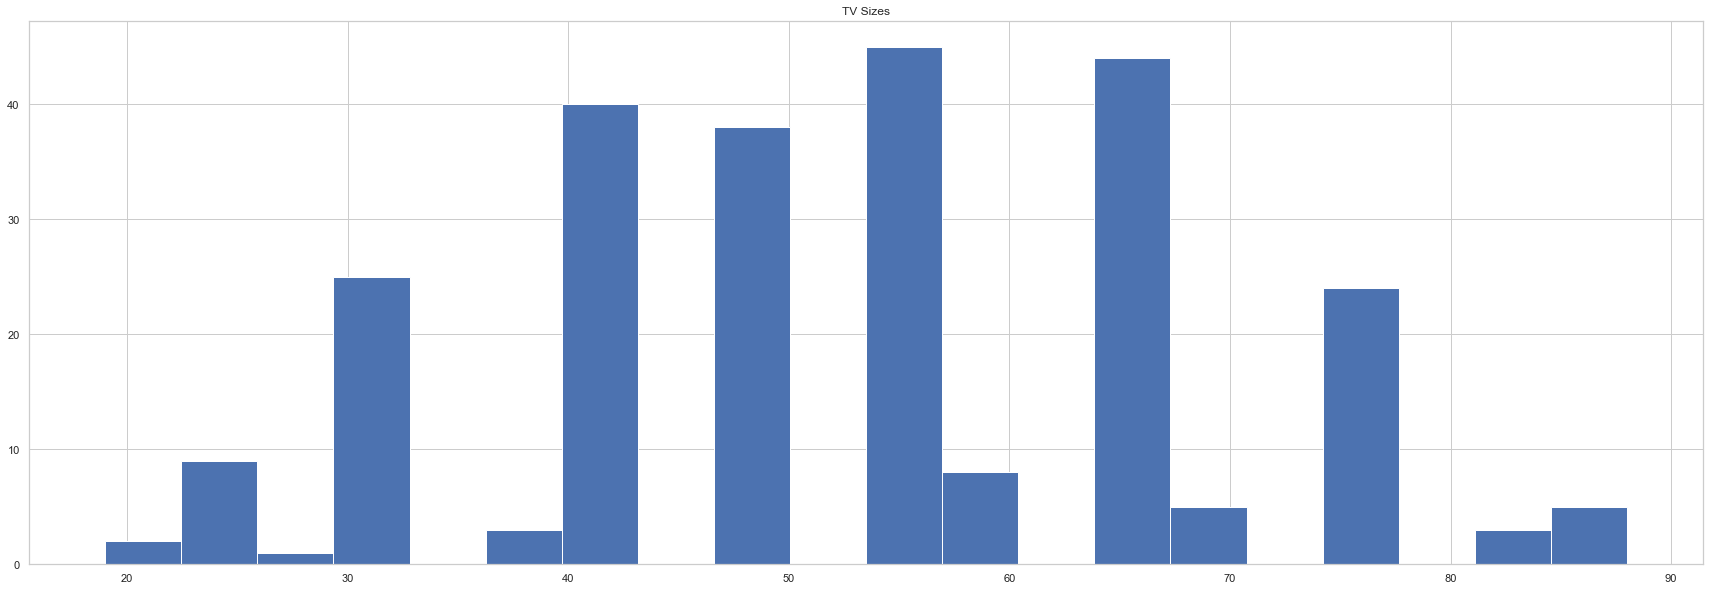

In [8]:
f, ax = plt.subplots(figsize=(30, 10))
plt.title('TV Sizes')
plt.hist(df.Size, bins=20)
plt.show

Text(0.5,1,'Price Range by Brand')

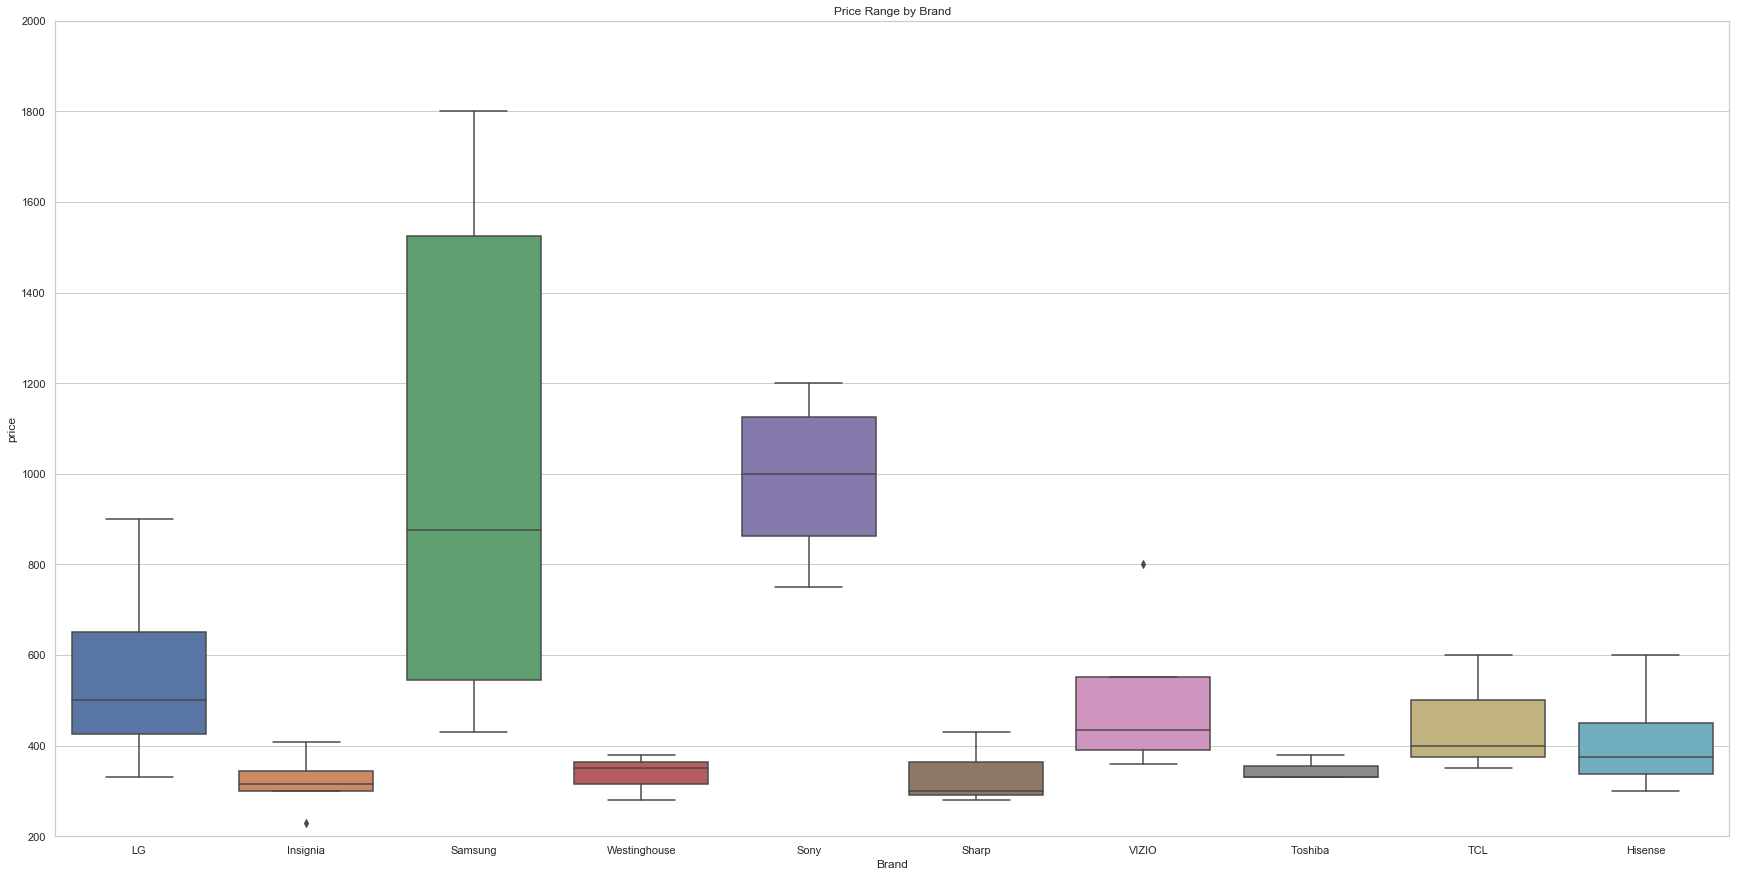

In [9]:
#g = sns.FacetGrid(df, col="Brand", size=4, aspect=.5)
f, ax = plt.subplots(figsize=(30, 15))
plt.ylim(200,2000)
plt.rcParams['font.size'] = 50
g = sns.boxplot(data=df[(df.Class == 'LED') & (df.Brand != 'SunBriteTV') & (df.price > 0) & 
                        (df.Size >= 50) & (df.Size <= 55)], x="Brand", y="price")

plt.title('Price Range by Brand')